# ORF recognition by Convolutional/Recurrent

Test CNN+LSTM 32 on simulated RNA of length 64. 

Use restructured codebase from notebook 105.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 14:29:32 UTC'

In [2]:
PC_SEQUENCES=32000   # how many protein-coding sequences
NC_SEQUENCES=32000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=64            # how long is each sequence
CDS_LEN=32            # min CDS len to be coding
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 32   # how many different patterns the model looks for
CELLS = 32
NEURONS = 32
DROP_RATE = 0.4
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=100  # how many times to train on all the data
SPLITS=3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=3  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
rbo=Random_Base_Oracle(RNA_LEN,True)
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

It took 33 trials to reach 10 per class.
It took 103346 trials to reach 33000 per class.
Use 33000 PC seqs
Use 33000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 64.0
Average ORF length: 38.39154545454546
NC seqs
Average RNA length: 64.0
Average ORF length: 8.377272727272727


In [7]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [8]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [9]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    #dnn.add(MaxPooling1D())
    #dnn.add(TimeDistributed(Flatten()))
    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (64, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 64, 32)            416       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 32, 32)            8320      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)         

In [10]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 53s 12ms/step - loss: 0.6973 - accuracy: 0.5362 - val_loss: 0.6178 - val_accuracy: 0.6478


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.6231 - accuracy: 0.6492 - val_loss: 0.5790 - val_accuracy: 0.6794


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5774 - accuracy: 0.6821 - val_loss: 0.5598 - val_accuracy: 0.6914


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5655 - accuracy: 0.6937 - val_loss: 0.5675 - val_accuracy: 0.6864
Epoch 5/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5584 - accuracy: 0.6987 - val_loss: 0.5463 - val_accuracy: 0.7031


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5471 - accuracy: 0.7070 - val_loss: 0.5448 - val_accuracy: 0.7065


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5388 - accuracy: 0.7092 - val_loss: 0.5408 - val_accuracy: 0.7077


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5337 - accuracy: 0.7140 - val_loss: 0.5380 - val_accuracy: 0.7106


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5301 - accuracy: 0.7181 - val_loss: 0.5322 - val_accuracy: 0.7101
Epoch 10/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5356 - accuracy: 0.7138 - val_loss: 0.5341 - val_accuracy: 0.7113


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5226 - accuracy: 0.7195 - val_loss: 0.5310 - val_accuracy: 0.7125


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5175 - accuracy: 0.7267 - val_loss: 0.5309 - val_accuracy: 0.7125
Epoch 13/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5147 - accuracy: 0.7232 - val_loss: 0.5298 - val_accuracy: 0.7121
Epoch 14/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5139 - accuracy: 0.7278 - val_loss: 0.5401 - val_accuracy: 0.7049
Epoch 15/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5065 - accuracy: 0.7326 - val_loss: 0.6213 - val_accuracy: 0.6818
Epoch 16/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.5208 - accuracy: 0.7228 - val_loss: 0.5278 - val_accuracy: 0.7135


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 17/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4995 - accuracy: 0.7382 - val_loss: 0.5367 - val_accuracy: 0.7142


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 18/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4953 - accuracy: 0.7364 - val_loss: 0.5292 - val_accuracy: 0.7159


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 19/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4933 - accuracy: 0.7427 - val_loss: 0.5261 - val_accuracy: 0.7184


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4908 - accuracy: 0.7450 - val_loss: 0.5225 - val_accuracy: 0.7266


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4796 - accuracy: 0.7519 - val_loss: 0.5802 - val_accuracy: 0.6883
Epoch 22/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5120 - accuracy: 0.7327 - val_loss: 0.5146 - val_accuracy: 0.7322


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4720 - accuracy: 0.7562 - val_loss: 0.5143 - val_accuracy: 0.7299
Epoch 24/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4681 - accuracy: 0.7593 - val_loss: 0.5112 - val_accuracy: 0.7324


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 25/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4629 - accuracy: 0.7650 - val_loss: 0.5176 - val_accuracy: 0.7285
Epoch 26/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4601 - accuracy: 0.7649 - val_loss: 0.5091 - val_accuracy: 0.7329


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4559 - accuracy: 0.7688 - val_loss: 0.5195 - val_accuracy: 0.7311
Epoch 28/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4455 - accuracy: 0.7751 - val_loss: 0.5062 - val_accuracy: 0.7368


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.4813 - accuracy: 0.7548 - val_loss: 0.5071 - val_accuracy: 0.7384


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 30/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4508 - accuracy: 0.7725 - val_loss: 0.5043 - val_accuracy: 0.7390


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 31/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4416 - accuracy: 0.7757 - val_loss: 0.5112 - val_accuracy: 0.7409


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4378 - accuracy: 0.7803 - val_loss: 0.5053 - val_accuracy: 0.7444


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 33/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4284 - accuracy: 0.7861 - val_loss: 0.5024 - val_accuracy: 0.7412
Epoch 34/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4256 - accuracy: 0.7845 - val_loss: 0.5069 - val_accuracy: 0.7463


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 35/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4256 - accuracy: 0.7884 - val_loss: 0.5019 - val_accuracy: 0.7485


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.4207 - accuracy: 0.7898 - val_loss: 0.5064 - val_accuracy: 0.7494


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 37/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4103 - accuracy: 0.7955 - val_loss: 0.5054 - val_accuracy: 0.7490
Epoch 38/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.4084 - accuracy: 0.7957 - val_loss: 0.4982 - val_accuracy: 0.7521


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.4087 - accuracy: 0.7963 - val_loss: 0.4939 - val_accuracy: 0.7526


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.3970 - accuracy: 0.8041 - val_loss: 0.4975 - val_accuracy: 0.7519
Epoch 41/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.3927 - accuracy: 0.8033 - val_loss: 0.4976 - val_accuracy: 0.7558


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 42/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.3924 - accuracy: 0.8075 - val_loss: 0.5088 - val_accuracy: 0.7553
Epoch 43/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.3840 - accuracy: 0.8084 - val_loss: 0.5161 - val_accuracy: 0.7539
Epoch 44/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.3899 - accuracy: 0.8090 - val_loss: 0.6353 - val_accuracy: 0.6250
Epoch 45/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.6366 - accuracy: 0.6281 - val_loss: 0.6138 - val_accuracy: 0.6497
Epoch 46/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.6007 - accuracy: 0.6655 - val_loss: 0.5535 - val_accuracy: 0.6949
Epoch 47/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5564 - accuracy: 0.7005 - val_loss: 0.5453 - val_accuracy: 0.7034
Epoch 48/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5294 - accuracy: 0.7180 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 52/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.1386 - accuracy: 0.9495 - val_loss: 0.1149 - val_accuracy: 0.9523


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 53/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.1477 - accuracy: 0.9428 - val_loss: 0.1330 - val_accuracy: 0.9515
Epoch 54/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.1217 - accuracy: 0.9520 - val_loss: 0.0866 - val_accuracy: 0.9631


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 55/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0909 - accuracy: 0.9620 - val_loss: 0.0918 - val_accuracy: 0.9619
Epoch 56/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0833 - accuracy: 0.9663 - val_loss: 0.0919 - val_accuracy: 0.9618
Epoch 57/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0803 - accuracy: 0.9677 - val_loss: 0.0711 - val_accuracy: 0.9697


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 58/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0784 - accuracy: 0.9676 - val_loss: 0.0679 - val_accuracy: 0.9694
Epoch 59/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0642 - accuracy: 0.9716 - val_loss: 0.0779 - val_accuracy: 0.9672
Epoch 60/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0686 - accuracy: 0.9723 - val_loss: 0.0536 - val_accuracy: 0.9766


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 61/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0592 - accuracy: 0.9745 - val_loss: 0.0548 - val_accuracy: 0.9768


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 62/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0620 - accuracy: 0.9755 - val_loss: 0.0510 - val_accuracy: 0.9774


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 63/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0493 - accuracy: 0.9800 - val_loss: 0.0492 - val_accuracy: 0.9802


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 64/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0419 - accuracy: 0.9845 - val_loss: 0.0423 - val_accuracy: 0.9852


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 65/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0349 - accuracy: 0.9873 - val_loss: 0.0336 - val_accuracy: 0.9882


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 66/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0378 - accuracy: 0.9868 - val_loss: 0.0360 - val_accuracy: 0.9871
Epoch 67/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0232 - accuracy: 0.9921 - val_loss: 0.0295 - val_accuracy: 0.9889


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 68/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0199 - accuracy: 0.9926 - val_loss: 0.0241 - val_accuracy: 0.9908


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 69/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0380 - accuracy: 0.9877 - val_loss: 0.0287 - val_accuracy: 0.9881
Epoch 70/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0170 - accuracy: 0.9931 - val_loss: 0.0196 - val_accuracy: 0.9926


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 71/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0152 - accuracy: 0.9948 - val_loss: 0.0167 - val_accuracy: 0.9942


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 72/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0160 - accuracy: 0.9949 - val_loss: 0.0256 - val_accuracy: 0.9904
Epoch 73/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 0.0227 - val_accuracy: 0.9923
Epoch 74/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.0109 - accuracy: 0.9963 - val_loss: 0.0191 - val_accuracy: 0.9940
Epoch 75/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0291 - val_accuracy: 0.9903
Epoch 76/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0172 - accuracy: 0.9944 - val_loss: 0.0259 - val_accuracy: 0.9925
Epoch 77/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.0180 - val_accuracy: 0.9940
Epoch 78/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0162 - accuracy: 0.9957 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 79/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0076 - accuracy: 0.9979 - val_loss: 0.0164 - val_accuracy: 0.9957


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 80/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.0150 - val_accuracy: 0.9947
Epoch 81/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0133 - val_accuracy: 0.9951
Epoch 82/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.0244 - val_accuracy: 0.9924
Epoch 83/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0157 - val_accuracy: 0.9954
Epoch 84/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0151 - accuracy: 0.9955 - val_loss: 0.0148 - val_accuracy: 0.9955
Epoch 85/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.0205 - val_accuracy: 0.9937
Epoch 86/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.0076 - accuracy: 0.9973 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 91/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0180 - val_accuracy: 0.9937
Epoch 92/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0047 - accuracy: 0.9989 - val_loss: 0.0124 - val_accuracy: 0.9970


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 93/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0040 - accuracy: 0.9991 - val_loss: 0.0139 - val_accuracy: 0.9962
Epoch 94/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0102 - val_accuracy: 0.9966
Epoch 95/100
1334/1334 [==============================] - 14s 11ms/step - loss: 0.0111 - accuracy: 0.9975 - val_loss: 0.0116 - val_accuracy: 0.9967
Epoch 96/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0107 - val_accuracy: 0.9966
Epoch 97/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.1804 - val_accuracy: 0.9741
Epoch 98/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0277 - accuracy: 0.9941 - val_loss: 0.0165 - val_accuracy: 0.9954
Epoch 99/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.0039 - accuracy: 0.9990 - val_

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Fold 1, 100 epochs, 2083 sec


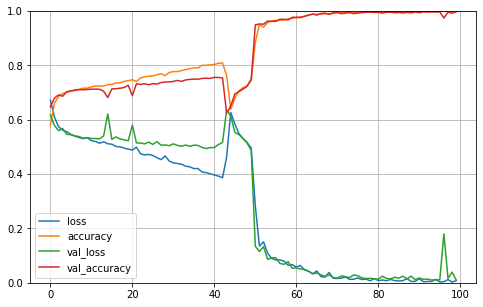

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 20s 12ms/step - loss: 0.6919 - accuracy: 0.5445 - val_loss: 0.6219 - val_accuracy: 0.6432
Epoch 2/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.6240 - accuracy: 0.6442 - val_loss: 0.5921 - val_accuracy: 0.6718
Epoch 3/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5801 - accuracy: 0.6805 - val_loss: 0.5578 - val_accuracy: 0.6951
Epoch 4/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5599 - accuracy: 0.6958 - val_loss: 0.5459 - val_accuracy: 0.7030
Epoch 5/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5464 - accuracy: 0.7022 - val_loss: 0.5453 - val_accuracy: 0.7007
Epoch 6/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5379 - accuracy: 0.7108 - val_loss: 0.5511 - val_accuracy: 0.7021
Epoch 7/100
1334/1334 [==============================] - 15s 11ms/step - loss:

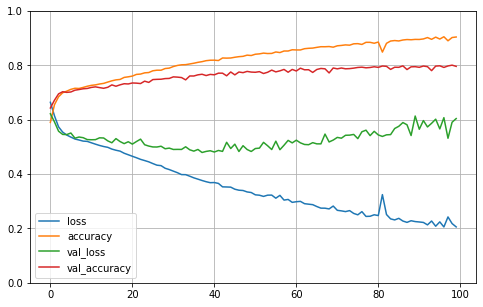

MODEL
make_DNN
input shape: (64, 4)
FIT
Epoch 1/100
1334/1334 [==============================] - 20s 12ms/step - loss: 0.6827 - accuracy: 0.5614 - val_loss: 0.6190 - val_accuracy: 0.6487
Epoch 2/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.6070 - accuracy: 0.6618 - val_loss: 0.5644 - val_accuracy: 0.6939
Epoch 3/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5644 - accuracy: 0.6913 - val_loss: 0.5601 - val_accuracy: 0.6951
Epoch 4/100
1334/1334 [==============================] - 17s 13ms/step - loss: 0.5589 - accuracy: 0.6956 - val_loss: 0.5475 - val_accuracy: 0.7027
Epoch 5/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5477 - accuracy: 0.7035 - val_loss: 0.5488 - val_accuracy: 0.7034
Epoch 6/100
1334/1334 [==============================] - 15s 11ms/step - loss: 0.5363 - accuracy: 0.7139 - val_loss: 0.5388 - val_accuracy: 0.7093
Epoch 7/100
1334/1334 [==============================] - 15s 11ms/step - loss:

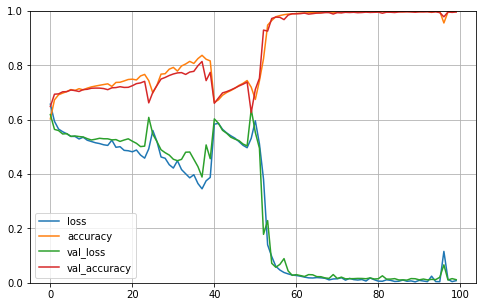

In [11]:
do_cross_validation(X,y)

In [12]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 99.60%


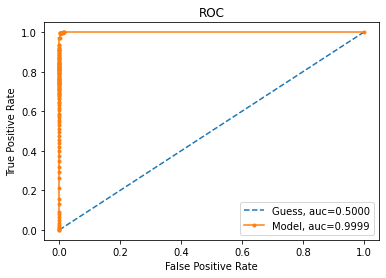

AUC: 99.99%


In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [14]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-21 15:55:04 UTC'